In [1]:
print("""
@File         : predicting_market_movements_with_machine_learning.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-05-07 22:51:27
@Email        : cuixuanstephen@gmail.com
@Description  : 
""")


@File         : predicting_market_movements_with_machine_learning.ipynb
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2024-05-07 22:51:27
@Email        : cuixuanstephen@gmail.com
@Description  : 



In [2]:
%cd ../../

d:\Quantitative\P4AT


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams["figure.figsize"] = (10, 6)
plt.style.use("ggplot")
plt.rcParams["savefig.dpi"] = 300
os.environ["PYTHONHASHSEED"] = '0'

x = np.linspace(0, 10)
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)

set_seeds()
y = x+np.random.standard_normal(len(x))
reg = np.polyfit(x, y, deg=1)

In [4]:
reg

array([0.94612934, 0.22855261])

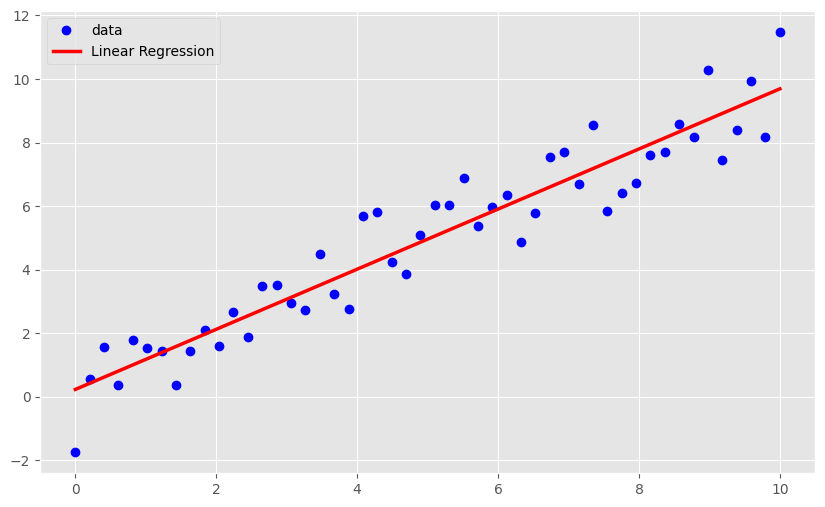

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, "bo", label="data")
plt.plot(x, np.polyval(reg, x), "r", lw=2.5, label="Linear Regression")
plt.legend(loc=0)

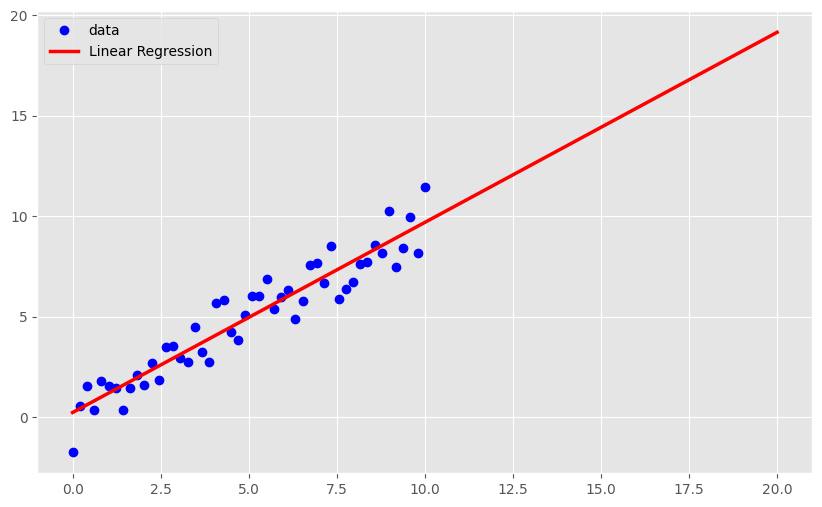

In [6]:
plt.figure()
plt.plot(x, y, "bo", label="data")
xn = np.linspace(0, 20)
plt.plot(xn, np.polyval(reg, xn), "r", lw=2.5, label="Linear Regression")
plt.legend(loc=0)

In [7]:
x = np.arange(12)
lags = 3

m = np.zeros((lags + 1, len(x) - lags))
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i : i - lags]

In [8]:
m

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

In [9]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)[0]

In [10]:
np.linalg.lstsq(m[:lags].T, m[lags], rcond=None)

(array([-0.66666667,  0.33333333,  1.33333333]),
 array([], dtype=float64),
 2,
 array([2.94834317e+01, 1.93060965e+00, 1.69780584e-16]))

In [11]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [12]:
np.dot(m[:lags].T, reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [13]:
import pandas as pd

In [14]:
raw = pd.read_csv(
    "data/pyalgo_eikon_eod_data.csv", index_col=0, parse_dates=True
).dropna()

In [15]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [16]:
symbol = "EUR="
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: "price"}, inplace=True)

In [17]:
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["price"].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [18]:
reg = np.linalg.lstsq(data[cols], data["price"], rcond=None)[0]

In [19]:
reg

array([ 0.98635864,  0.02292172, -0.04769849,  0.05037365, -0.01208135])

<Axes: xlabel='Date'>

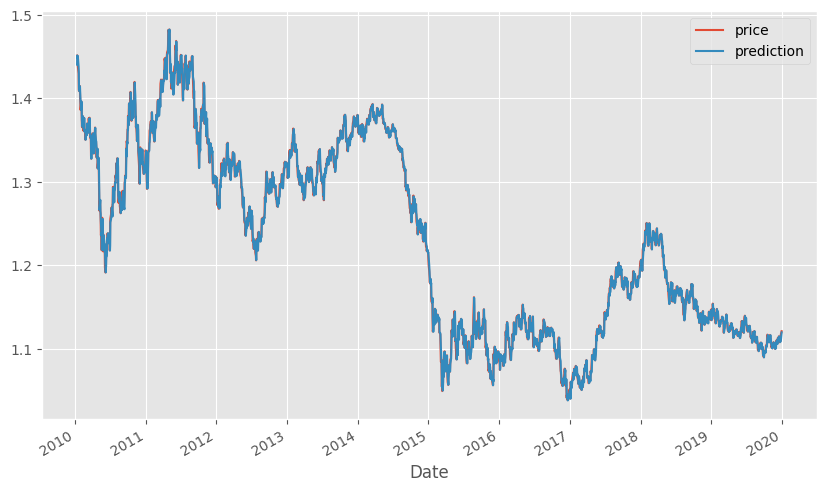

In [20]:
data["prediction"] = np.dot(data[cols], reg)
data[["price", "prediction"]].plot()

<Axes: xlabel='Date'>

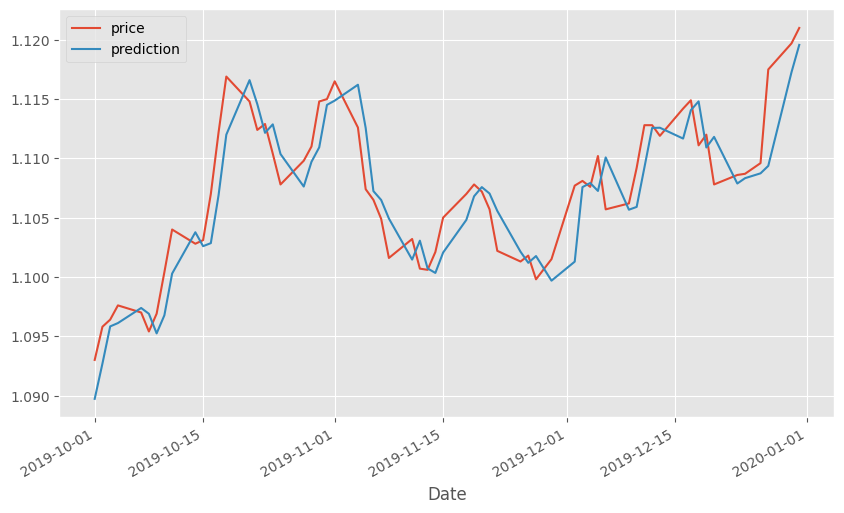

In [21]:
data[["price", "prediction"]].loc['2019-10-01':].plot()

### 预测未来收益

In [22]:
data["return"] = data["price"].apply(np.log).diff()
data.dropna(inplace=True)
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["return"].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [23]:
reg = np.linalg.lstsq(data[cols], data["return"], rcond=None)[0]

In [24]:
reg

array([-0.015689  ,  0.00890227, -0.03634858,  0.01290924, -0.00636023])

In [25]:
data["prediction"] = np.dot(data[cols], reg)

<Axes: xlabel='Date'>

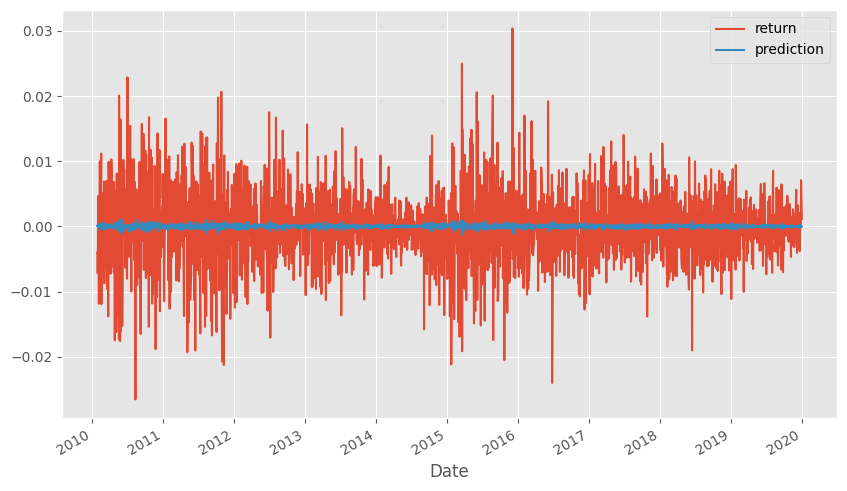

In [26]:
data[["return", "prediction"]].iloc[lags:].plot()

In [27]:
hits = np.sign(data["return"] * data["prediction"]).value_counts()
hits

 1.0    1250
-1.0    1242
 0.0      13
Name: count, dtype: int64

In [28]:
hits.loc[1.0] / sum(hits)

0.499001996007984

### 预测未来市场方向

用收益的正负号作为预测值，而不是收益。

In [29]:
reg = np.linalg.lstsq(data[cols], np.sign(data["return"]), rcond=None)[0]
reg

array([-5.11938725, -2.24077248, -5.13080606, -3.03753232, -2.14819119])

In [30]:
data["prediction"] = np.sign(np.dot(data[cols], reg))

In [31]:
data['prediction'].value_counts()

prediction
 1.0    1300
-1.0    1205
Name: count, dtype: int64

In [32]:
hits = np.sign(data['return'] * data['prediction']).value_counts()
hits

 1.0    1301
-1.0    1191
 0.0      13
Name: count, dtype: int64

In [33]:
hits.loc[1.0] / hits.sum()

0.5193612774451097

In [34]:
from utils.strategy.ml import LRVectorBacktest

In [35]:
lr = LRVectorBacktest('EUR=', '2010-01-01', '2019-12-31', 10_000, 0.00025)

In [36]:
lr.run_strategy('2010-01-01', '2019-12-31', '2010-01-01', '2019-12-31', lags=5)

(14417.77, 6693.66)

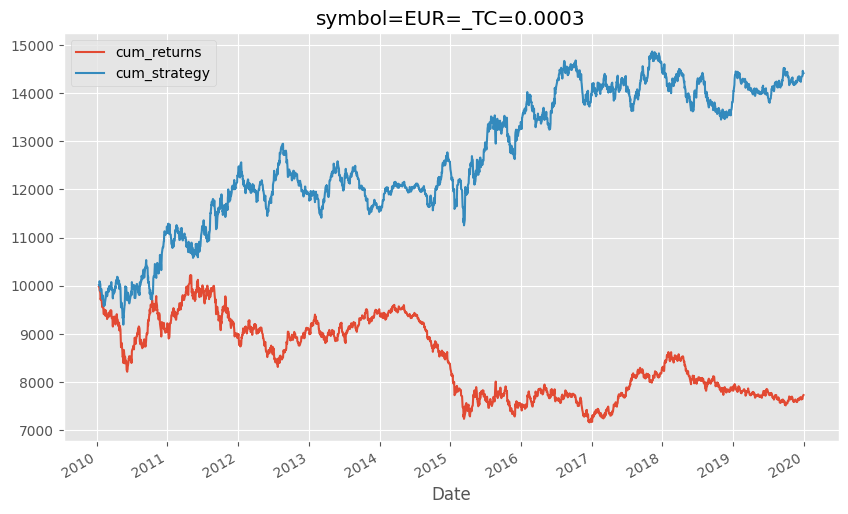

In [37]:
lr.plot_results()

In [38]:
lr.run_strategy('2010-01-01', '2017-12-31', '2018-01-01', '2019-12-31', lags=5)

(9760.01, 391.01)

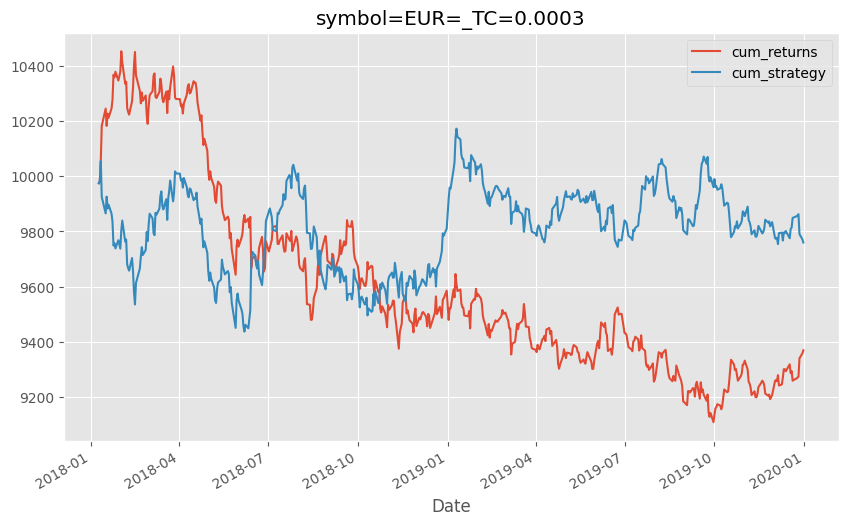

In [39]:
lr.plot_results()

In [40]:
lr = LRVectorBacktest('GDX', '2010-01-01', '2019-12-31', 
                      10000, 0.002)

In [41]:
lr.run_strategy('2010-01-01', '2019-12-31', '2010-01-01', '2019-12-31', lags=7)

(23642.32, 17649.69)

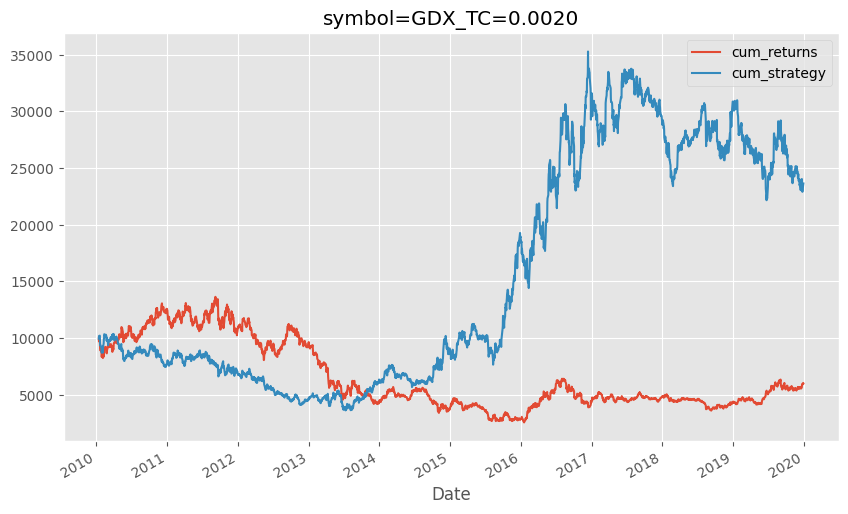

In [42]:
lr.plot_results()

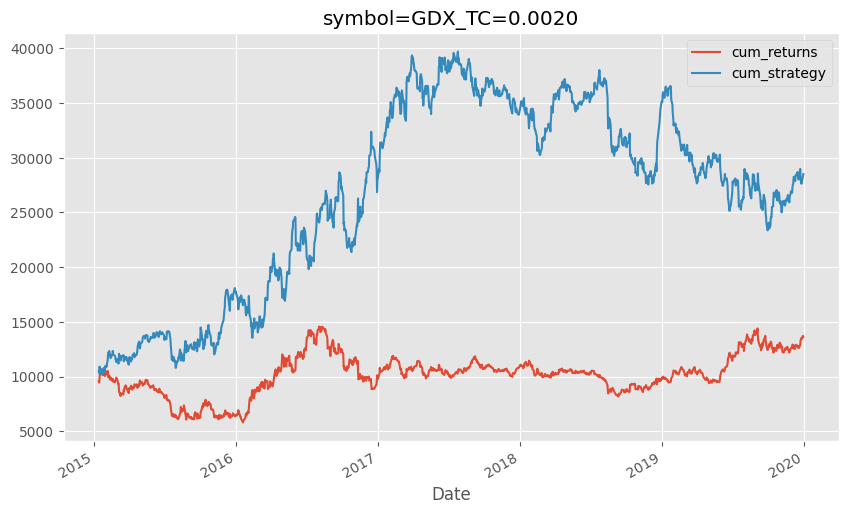

In [43]:
lr.run_strategy('2010-01-01', '2014-12-31', '2015-01-01', '2019-12-31', lags=7)
lr.plot_results()

In [44]:
lr.results

,price,returns,prediction,strategy,cum_returns,cum_strategy
Date,,,,,,
2015-01-13,20.55,-0.044727,-1.0,0.044727,9562.587250,10457.420925
2015-01-14,20.31,-0.011748,1.0,-0.013748,9450.907399,10314.640537
2015-01-15,21.48,0.056009,1.0,0.056009,9995.346673,10908.836964
2015-01-16,22.16,0.031167,-1.0,-0.033167,10311.772918,10552.962215
2015-01-20,22.94,0.034593,-1.0,-0.034593,10674.732434,10194.143099
...,...,...,...,...,...,...
2019-12-24,28.66,0.031546,-1.0,-0.033546,13336.435551,28030.078368
2019-12-26,29.08,0.014548,-1.0,-0.014548,13531.875291,27625.242298
2019-12-27,28.87,-0.007248,-1.0,0.007248,13434.155421,27826.187947


## 使用机器学习进行市场动向预测

In [45]:
x = np.arange(12)
lags = 3

In [46]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [47]:
m = np.zeros((lags + 1, len(x) - lags))

In [48]:
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i : i - lags]

In [49]:
m

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

In [50]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(m[:lags].T, m[lags])

LinearRegression()

In [51]:
lr.coef_

array([0.33333333, 0.33333333, 0.33333333])

In [52]:
lr.intercept_

2.0000000000000018

In [53]:
lr.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [54]:
lr = LinearRegression(fit_intercept=False)
lr.fit(m[:lags].T, m[lags])

LinearRegression(fit_intercept=False)

In [55]:
lr.coef_

array([-0.66666667,  0.33333333,  1.33333333])

In [56]:
lr.intercept_

0.0

In [57]:
lr.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [58]:
hours = np.array(
    [
        0.5,
        0.75,
        1.0,
        1.25,
        1.5,
        1.75,
        1.75,
        2.0,
        2.25,
        2.5,
        2.75,
        3.0,
        3.25,
        3.5,
        4.0,
        4.25,
        4.5,
        4.75,
        5.0,
        5.5,
    ]
)
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [59]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

(-0.2, 1.2)

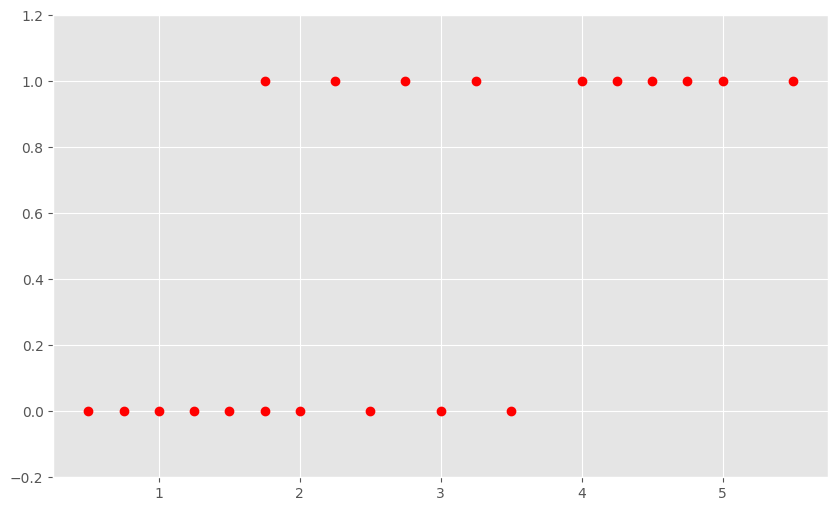

In [60]:
plt.figure()
plt.plot(hours, success, 'ro')
plt.ylim(-.2, 1.2)

In [61]:
reg = np.polyfit(hours, success, deg=1)

(-0.2, 1.2)

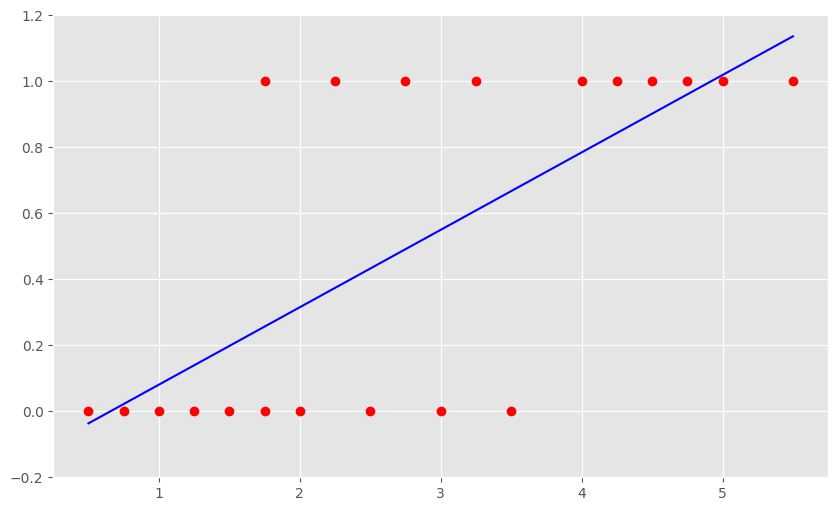

In [62]:
plt.figure()
plt.plot(hours, success, 'ro')
plt.plot(hours, np.polyval(reg, hours), 'b')
plt.ylim(-.2, 1.2)

In [63]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(solver="lbfgs")
hrs = hours.reshape(-1, 1)
lg.fit(hrs, success)

LogisticRegression()

In [64]:
prediction = lg.predict(hrs)
prob = lg.predict_proba(hrs)

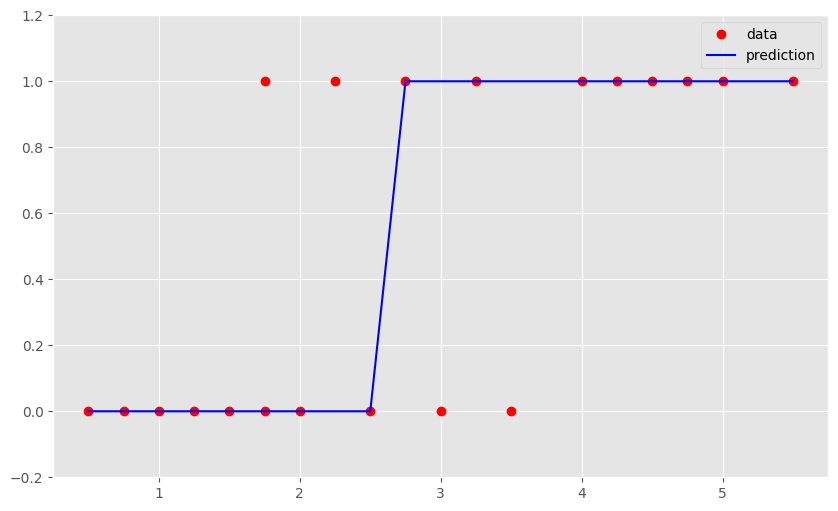

In [65]:
plt.figure()
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.ylim(-.2, 1.2)
plt.legend()

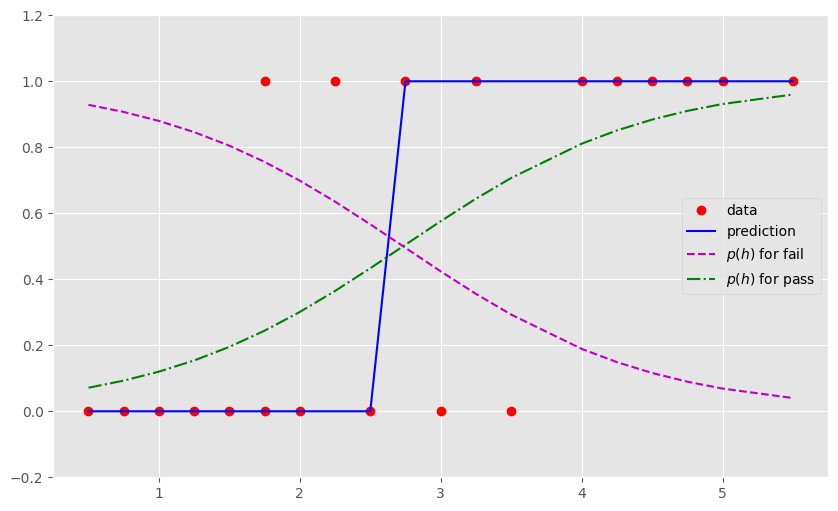

In [66]:
plt.figure()
plt.plot(hours, success, 'ro', label='data')
plt.plot(hours, prediction, 'b', label='prediction')
plt.plot(hours, prob[:, 0], 'm--', label='$p(h)$ for fail')
plt.plot(hours, prob[:, 1], 'g-.', label='$p(h)$ for pass')
plt.ylim(-.2, 1.2)
plt.legend()

In [67]:
prob[:, 0]

array([0.92861721, 0.90707537, 0.87987361, 0.84606045, 0.80484065,
       0.75576968, 0.75576968, 0.69897507, 0.63534559, 0.56660579,
       0.49520342, 0.42399618, 0.35581092, 0.2930129 , 0.18920231,
       0.14900776, 0.11612919, 0.08974025, 0.06888056, 0.03998596])

In [68]:
symbol = "GLD"
data = pd.DataFrame(raw[symbol])

data.rename(columns={symbol: "price"}, inplace=True)
data["return"] = data["price"].apply(np.log).diff()
data.dropna(inplace=True)
lags = 3
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["return"].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

from sklearn.metrics import accuracy_score

lg = LogisticRegression(C=1e7, solver="lbfgs", multi_class="auto", max_iter=1_000)
lg.fit(data[cols], np.sign(data["return"]))
data["prediction"] = lg.predict(data[cols])

In [69]:
from sklearn.metrics import accuracy_score

lg = LogisticRegression(C=1e7, solver="lbfgs", multi_class="auto", max_iter=1_000)
lg.fit(data[cols], np.sign(data["return"]))
data["prediction"] = lg.predict(data[cols])

In [70]:
data['prediction'].value_counts()

prediction
 1.0    1975
-1.0     537
Name: count, dtype: int64

In [71]:
data.head(10)

,price,return,lag_1,lag_2,lag_3,prediction
Date,,,,,,
2010-01-08,111.37,0.004951,-0.006207,0.016365,-0.000911,1.0
2010-01-11,112.85,0.013202,0.004951,-0.006207,0.016365,1.0
2010-01-12,110.49,-0.021134,0.013202,0.004951,-0.006207,-1.0
2010-01-13,111.54,0.009458,-0.021134,0.013202,0.004951,1.0
2010-01-14,112.03,0.004383,0.009458,-0.021134,0.013202,-1.0
2010-01-15,110.86,-0.010499,0.004383,0.009458,-0.021134,1.0
2010-01-19,111.52,0.005936,-0.010499,0.004383,0.009458,1.0
2010-01-20,108.94,-0.023407,0.005936,-0.010499,0.004383,-1.0
2010-01-21,107.37,-0.014516,-0.023407,0.005936,-0.010499,1.0


In [72]:
hits = np.sign(
    data["return"].iloc[lags:] * data["prediction"].iloc[lags:]
).value_counts()

In [73]:
hits

 1.0    1344
-1.0    1153
 0.0      12
Name: count, dtype: int64

In [74]:
accuracy_score(np.sign(data['return']), data['prediction'])

0.5362261146496815

In [75]:
data["strategy"] = data["prediction"] * data["return"]
data[["return", "strategy"]].sum().apply(np.exp)

return      1.289478
strategy    2.469257
dtype: float64

<Axes: xlabel='Date'>

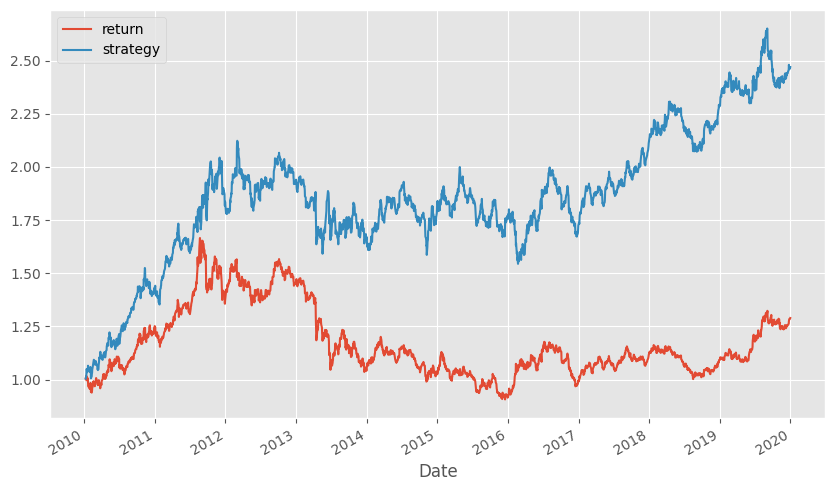

In [76]:
data[["return", "strategy"]].cumsum().apply(np.exp).plot()

<Axes: xlabel='Date'>

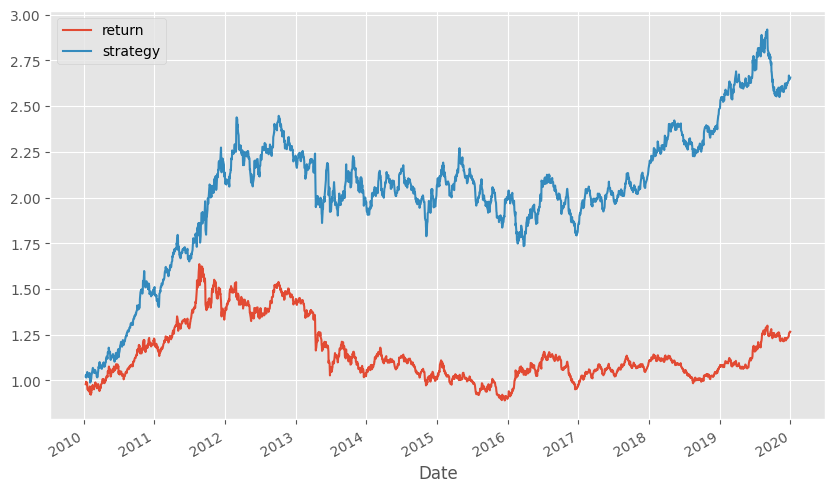

In [77]:
symbol = "GLD"
data = pd.DataFrame(raw[symbol])

data.rename(columns={symbol: "price"}, inplace=True)
data["return"] = data["price"].apply(np.log).diff()
data.dropna(inplace=True)
lags = 5
cols = []
for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["return"].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

from sklearn.metrics import accuracy_score

lg = LogisticRegression(C=1e7, solver="lbfgs", multi_class="auto", max_iter=1_000)
lg.fit(data[cols], np.sign(data["return"]))
data["prediction"] = lg.predict(data[cols])

hits = np.sign(
    data["return"].iloc[lags:] * data["prediction"].iloc[lags:]
).value_counts()

data["strategy"] = data["prediction"] * data["return"]
data[["return", "strategy"]].cumsum().apply(np.exp).plot()

In [78]:
hits

 1.0    1331
-1.0    1162
 0.0      12
Name: count, dtype: int64

In [79]:
accuracy_score(np.sign(data['return']), data['prediction'])

0.5314741035856574

In [80]:
from utils.ml.logistic_regression import LogisticRegressionVectorBacktest

In [81]:
sci_bt = LogisticRegressionVectorBacktest('EUR=', '2010-01-01', '2019-12-31',
                                          10_000, 0.0, 'logistic')

In [82]:
sci_bt.run_strategy('2015-01-01', '2019-12-31', '2015-01-01', '2019-12-31', lags=15)

(12757.88, 2755.2)

In [83]:
sci_bt.run_strategy('2016-01-01', '2019-12-31', '2019-01-01', '2019-12-31', lags=15)

(10711.41, 860.79)

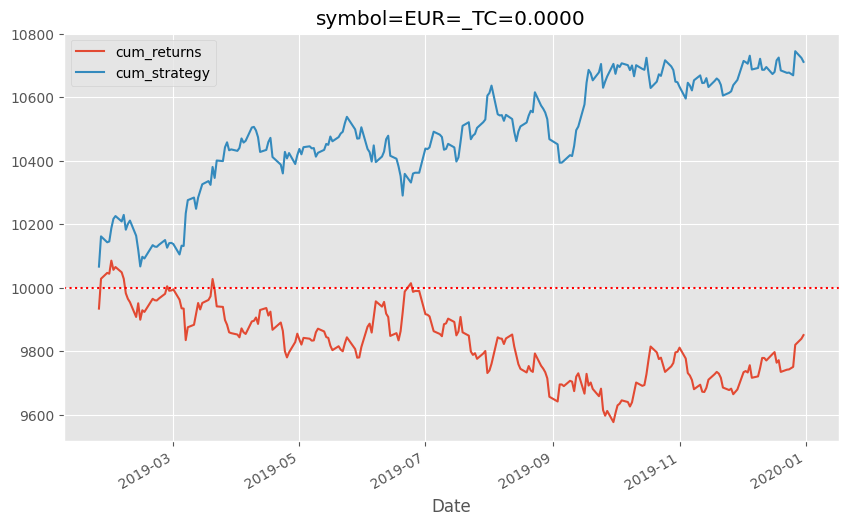

In [84]:
sci_bt.plot_results()

In [85]:
sci_bt = LogisticRegressionVectorBacktest('GDX', '2010-01-01', '2019-12-31', 
                                          10_000, 0.0, 'logistic')
sci_bt.run_strategy('2013-01-01', '2017-12-31', 
                    '2018-01-01', '2018-12-31', lags=10)

(12893.64, 4239.56)

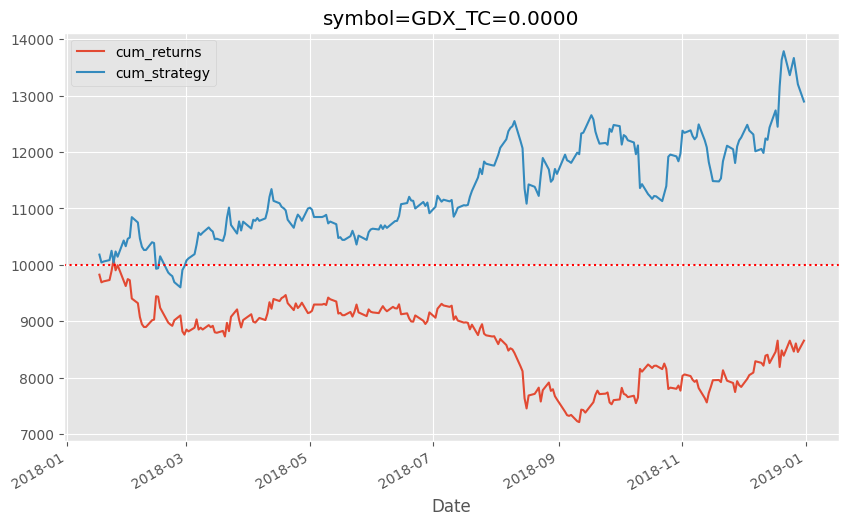

In [86]:
sci_bt.plot_results()

In [87]:
sci_bt = LogisticRegressionVectorBacktest('GDX', '2010-01-01', '2019-12-31', 
                                          10_000, 0.0025, 'logistic')
sci_bt.run_strategy('2013-01-01', '2017-12-31', 
                    '2018-01-01', '2018-12-31', lags=10)

(9744.8, 1090.72)

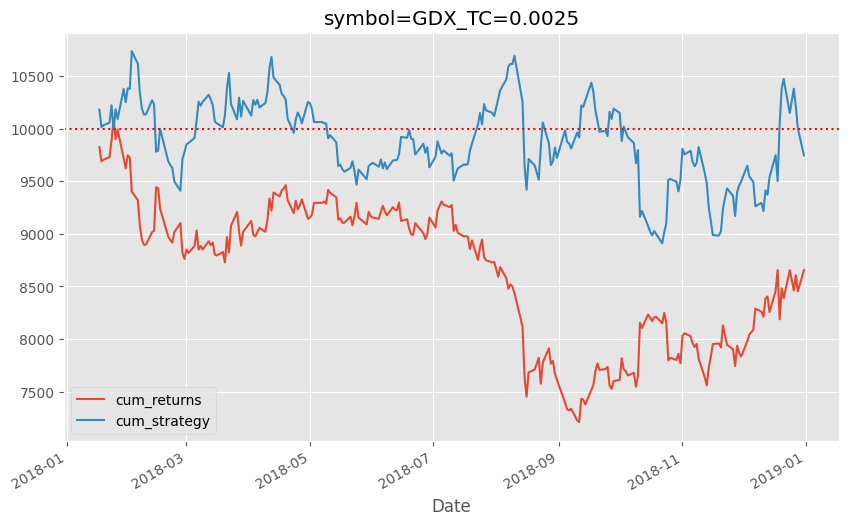

In [88]:
sci_bt.plot_results()

## 使用深度学习进行市场走势预测

In [89]:
hours = np.array(
    [
        0.5,
        0.75,
        1.0,
        1.25,
        1.5,
        1.75,
        1.75,
        2.0,
        2.25,
        2.5,
        2.75,
        3.0,
        3.25,
        3.5,
        4.0,
        4.25,
        4.5,
        4.75,
        5.0,
        5.5,
    ]
)
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

data = pd.DataFrame({"hours": hours, "success": success})

In [90]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=[32], max_iter=1_000, random_state=100)

In [91]:
model.fit(data["hours"].values.reshape(-1, 1), data["success"])

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [92]:
data["prediction"] = model.predict(data["hours"].values.reshape(-1, 1))

In [93]:
data.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


<Axes: xlabel='hours'>

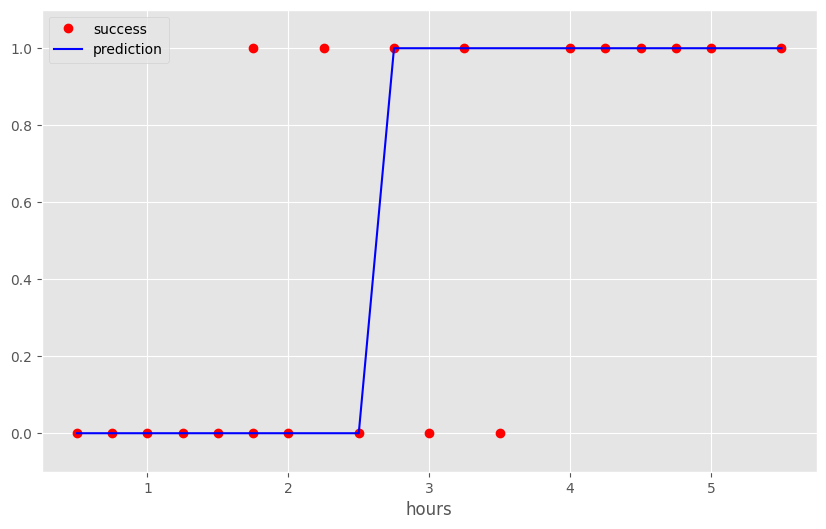

In [94]:
data.plot(x='hours', y=['success', 'prediction'], style=['ro', 'b-'],
          ylim=[-.1, 1.1])

In [139]:
symbol = "EUR="
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: "price"}, inplace=True)
data["return"] = data["price"].apply(np.log).diff()
data["direction"] = np.where(data["return"] > 0, 1, 0)
lags = 5
cols = [f"lag_{lag}" for lag in range(1, lags + 1)]
for lag, col in enumerate(cols, 1):
    data[col] = data["return"].shift(lag)
data.dropna(inplace=True)

In [140]:
data

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2010-01-12,1.4494,-0.001310,0,0.006984,0.006544,-0.006544,0.003058,-0.002988
2010-01-13,1.4510,0.001103,1,-0.001310,0.006984,0.006544,-0.006544,0.003058
2010-01-14,1.4502,-0.000551,0,0.001103,-0.001310,0.006984,0.006544,-0.006544
2010-01-15,1.4382,-0.008309,0,-0.000551,0.001103,-0.001310,0.006984,0.006544
2010-01-19,1.4298,-0.005858,0,-0.008309,-0.000551,0.001103,-0.001310,0.006984
...,...,...,...,...,...,...,...,...
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810


In [141]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

In [142]:
optimizer = Adam(learning_rate=1e-5)


def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


set_seeds()

In [143]:
model = Sequential()
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [144]:
cutoff = "2017-12-31"
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [145]:
%%time
model.fit(
    training_data[cols],
    training_data["direction"],
    epochs=50,
    verbose=False,
    validation_split=0.2,
    shuffle=False,
)

CPU times: total: 2.97 s
Wall time: 7.69 s


<Axes: >

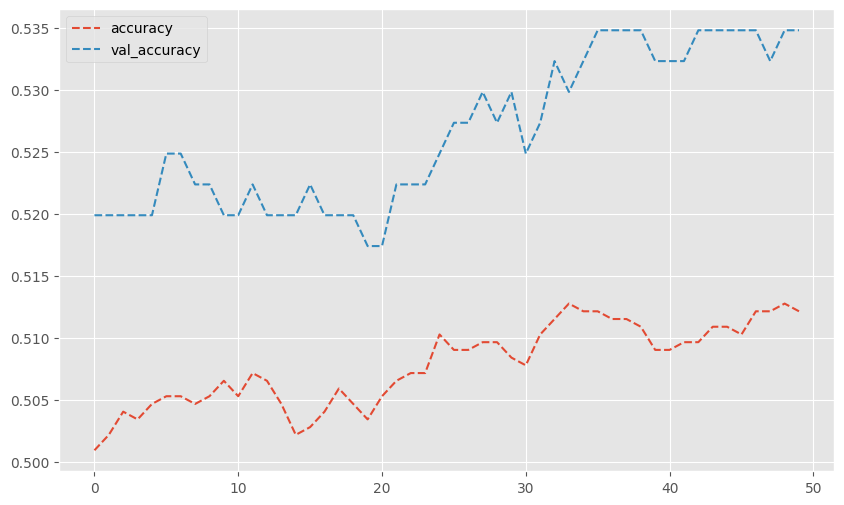

In [146]:
res = pd.DataFrame(model.history.history)
res[["accuracy", "val_accuracy"]].plot(style="--")

In [147]:
model.evaluate(training_data_[cols], training_data['direction'])

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5150 - loss: 0.7218


[0.719224750995636, 0.5062282085418701]

In [148]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
pred[:30].flatten()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [149]:
training_data['prediction'] = np.where(pred > 0, 1, -1)

In [150]:
training_data['strategy'] = (training_data['prediction'] * training_data['return'])

In [151]:
training_data[['return', 'strategy']].sum().apply(np.exp)

return      0.826569
strategy    0.903136
dtype: float64

<Axes: xlabel='Date'>

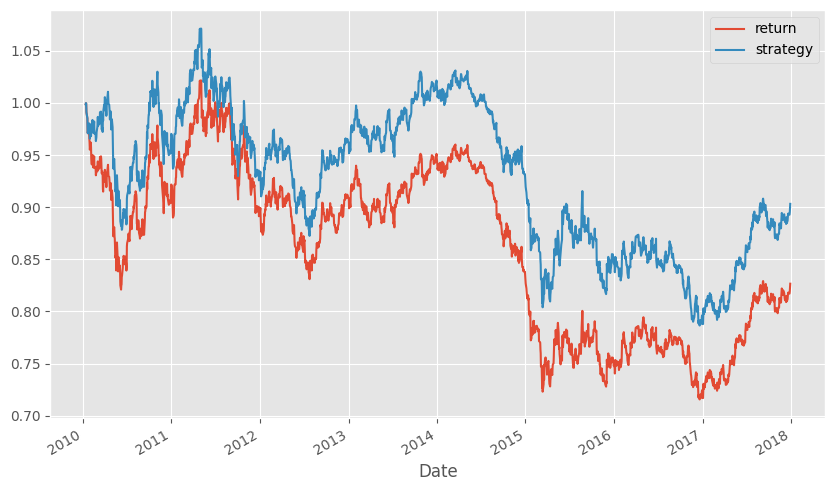

In [152]:
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot()

In [153]:
model.evaluate(test_data_[cols], test_data["direction"])

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.4922 - loss: 0.7112


[0.7121269106864929, 0.48310139775276184]

In [154]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, -1)
test_data["prediction"] = pred

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step


In [155]:
test_data['prediction'].value_counts()

prediction
 1    488
-1     15
Name: count, dtype: int64

In [156]:
test_data["strategy"] = test_data["prediction"] * test_data["return"]
test_data[["return", "strategy"]].sum().apply(np.exp)

return      0.934478
strategy    0.903394
dtype: float64

<Axes: xlabel='Date'>

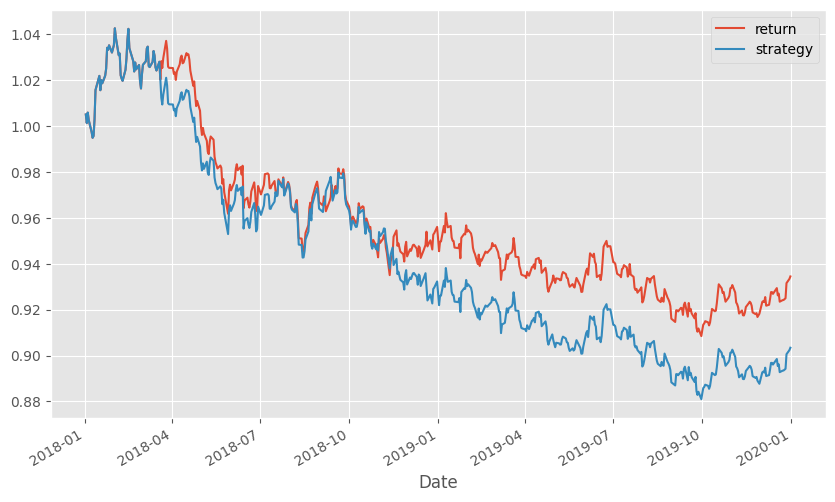

In [157]:
test_data[["return", "strategy"]].cumsum().apply(np.exp).plot()

In [158]:
data["momentum"] = data["return"].rolling(5).mean().shift(1)
data["volatility"] = data["return"].rolling(20).std().shift(1)
data["distance"] = (data["price"] - data["price"].rolling(50).mean()).shift()
data.dropna(inplace=True)
cols.extend(["momentum", "volatility", "distance"])

In [159]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2019-12-24,1.1087,0.0001,1,0.0007,-0.0038,0.0008,-0.0034,0.0006,-0.0010,0.0024,0.0005
2019-12-26,1.1096,0.0008,1,0.0001,0.0007,-0.0038,0.0008,-0.0034,-0.0011,0.0024,0.0004
2019-12-27,1.1175,0.0071,1,0.0008,0.0001,0.0007,-0.0038,0.0008,-0.0003,0.0024,0.0012
2019-12-30,1.1197,0.0020,1,0.0071,0.0008,0.0001,0.0007,-0.0038,0.0010,0.0028,0.0089
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0008,0.0001,0.0007,0.0021,0.0028,0.0110


In [228]:
optimizer = Adam(learning_rate=1e-4)
train = data[data.index < cutoff].copy()
mu, std = train.mean(), train.std()
train_ = (train - mu) / std
test = data[data.index >= cutoff].copy()
test_ = (test - mu) / std
set_seeds()
model = Sequential()
model.add(Dense(32, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [229]:
%%time
model.fit(train_[cols], train["direction"], verbose=False, epochs=25)

CPU times: total: 1.77 s
Wall time: 3.65 s


In [230]:
model.evaluate(train_[cols], train["direction"])

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5392 - loss: 0.6860


[0.6852320432662964, 0.5426673293113708]

In [231]:
pred = np.where(model.predict(train_[cols]) > 0.5, 1, -1)
train["prediction"] = pred
train["strategy"] = train["prediction"] * train["return"]

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [232]:
train[['return', 'strategy']].sum().apply(np.exp)

return      0.901074
strategy    2.483560
dtype: float64

<Axes: xlabel='Date'>

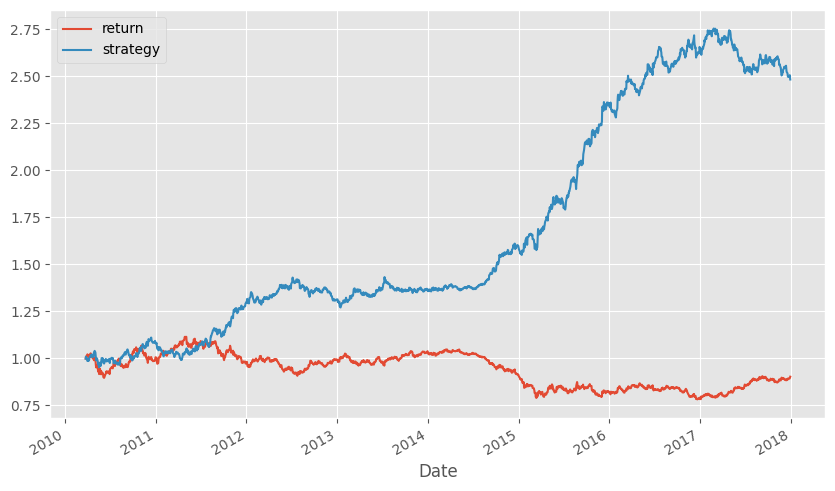

In [233]:
train[['return', 'strategy']].cumsum().apply(np.exp).plot()

In [234]:
model.evaluate(test_[cols], test["direction"])
pred = np.where(model.predict(test_[cols]) > 0.5, 1, -1)
test["prediction"] = pred
test["prediction"].value_counts()

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5192 - loss: 0.6924 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


prediction
-1    361
 1    142
Name: count, dtype: int64

In [235]:
test["strategy"] = test["prediction"] * test["return"]

In [236]:
test[['return', 'strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.135347
dtype: float64

<Axes: xlabel='Date'>

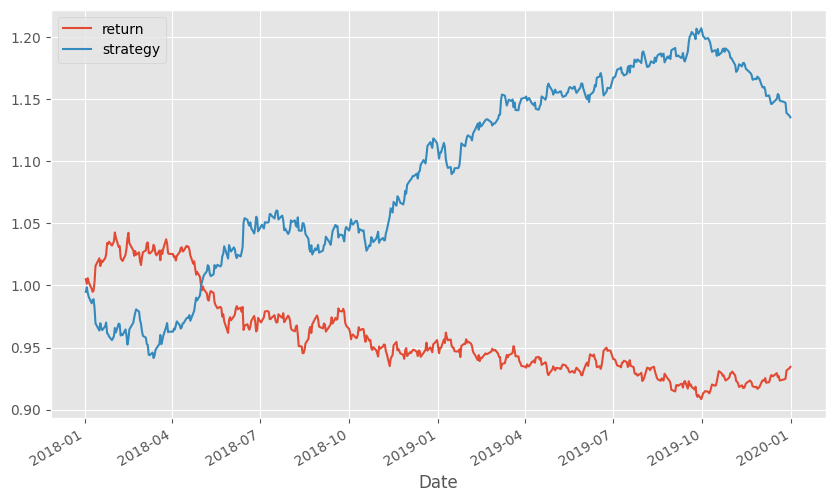

In [237]:
test[['return', 'strategy']].cumsum().apply(np.exp).plot()